In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# Data Processing
## Todo List
1. Calculate running totals and average wins/loses [DONE]
2. Generate Plots [DONE]
3. Assign skill scores
4. Create betting metrics/odds
5. Easy data entry mode

In [62]:
df_data = pd.read_csv("data.csv")
guests = ['oscar','nick','drew','ruohan','brandon','lixin','alice','eileen']
big3 = ['connor','helio','sam']
#Add a guest column
df_data['guest']= df_data[guests].sum(axis=1, min_count=1)
players = big3+guests+['guest']
df = df_data[players].fillna(0).cumsum()

# Mask non-played games to prevent graphing
df = df.mask(df_data[players].isna())

# Add a starting row at index -1 with all zeros to ensure graphs start at 0
start_row = pd.Series(0, index=players, name=-1)
df = pd.concat([pd.DataFrame([start_row]), df]).sort_index()

# For all players, ensure there's a connection from 0 to their first game
for p in players:
    first_idx = df_data[p].first_valid_index()
    if first_idx is not None and first_idx > 0:
        df.loc[first_idx - 1, p] = 0

#Convert to Dollars
df = df/100
#df.to_csv("results.csv", index = False)

In [63]:
# Data Validation: Check if hand scores sum to zero
all_players_check = ['sam','oscar','helio','connor','alice','ruohan','lixin','brandon','nick','drew','eileen']

# Sum across player columns (NaNs treated as 0)
row_sums = df_data[all_players_check].sum(axis=1)

# Find non-zero sums
non_zero_indices = row_sums[row_sums != 0].index

if not non_zero_indices.empty:
    print("ALERT: Data entry errors found! The following rows do not sum to zero:")
    for idx in non_zero_indices:
        date = df_data.loc[idx, 'date']
        game_num = df_data.loc[idx, 'game_num']
        total = row_sums[idx]
        print(f"Row {idx}: Date {date}, Game {game_num} -> Sum: {total}")
else:
    print("Data Validation Passed: All games sum to zero.")


Data Validation Passed: All games sum to zero.


## Some Basic Plots
We start with the net profit loss chart. 

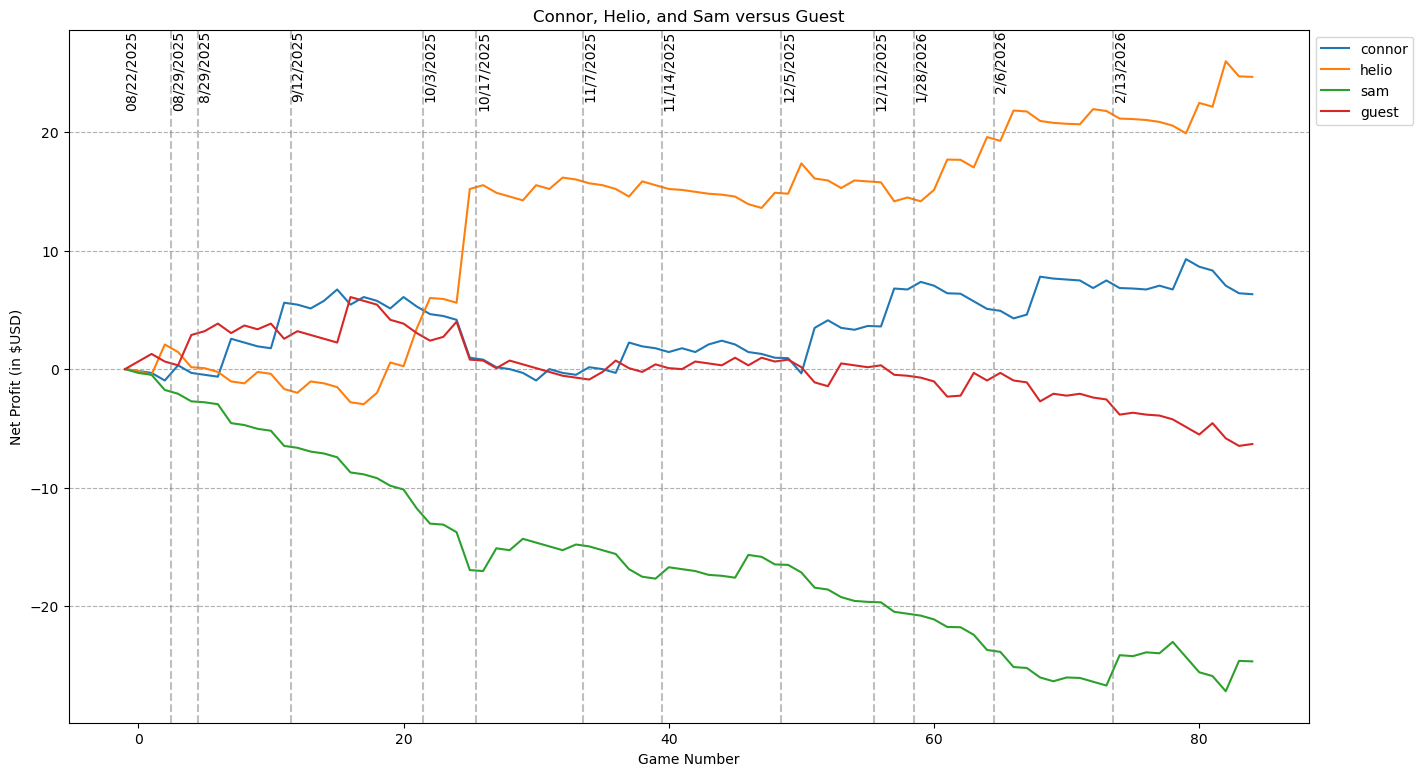

In [64]:
ax1 = df[big3+['guest']].plot(figsize=(16, 9))
ax1.set_title('Connor, Helio, and Sam versus Guest')

# Vertical bars for days with labels
y_min, y_max = ax1.get_ylim()
date_changes = df_data.index[df_data['date'].ne(df_data['date'].shift())].tolist()
for i in date_changes:
    if i == 0:
        plt.text(-1, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)
    else:
        plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.5)
        plt.text(i-0.5, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)

# Horizontal lines
plt.grid(axis='y', linestyle='--')

plt.xlabel("Game Number")
plt.ylabel("Net Profit (in $USD)")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("net_profit.png", bbox_inches='tight')


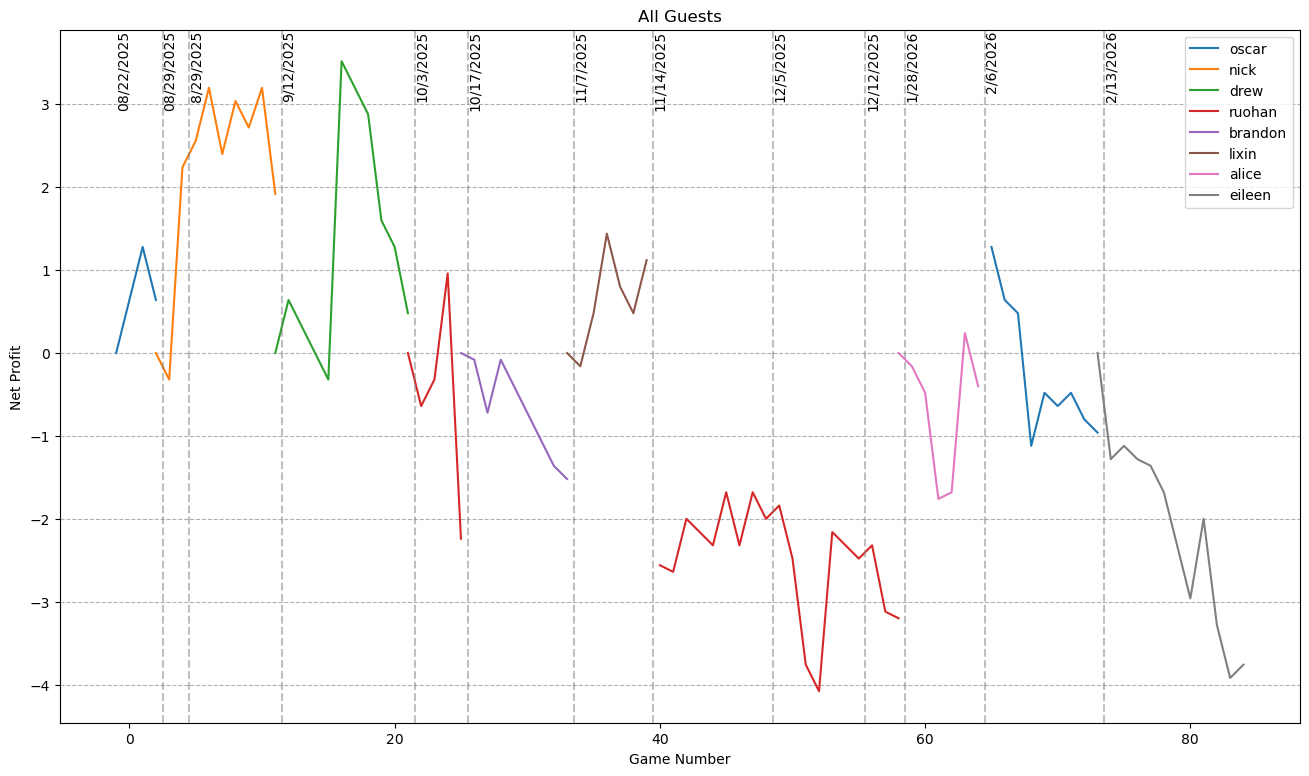

In [65]:

ax2 = df[guests].plot(figsize=(16, 9))
ax2.set_title('All Guests')

# Vertical bars for days with labels
y_min, y_max = ax2.get_ylim()
date_changes = df_data.index[df_data['date'].ne(df_data['date'].shift())].tolist()
for i in date_changes:
    if i == 0:
        plt.text(-1, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)
    else:
        plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.5)
        plt.text(i-0.5, y_max, df_data.loc[i, 'date'], rotation=90, verticalalignment='top', fontsize=10)

# Horizontal lines
plt.grid(axis='y', linestyle='--')

plt.xlabel("Game Number")
plt.ylabel("Net Profit")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.savefig("net_profit_guests.png", bbox_inches="tight")


## Autocorrelation Plots
An autocorrelogram shows that there appears to be a self correlation for low amounts of lag. The current theory for this is that this may be picking up the winning advantage of being dealer, and if someone wins while dealer they remain dealer hence giving a *hot hands* effect. 

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

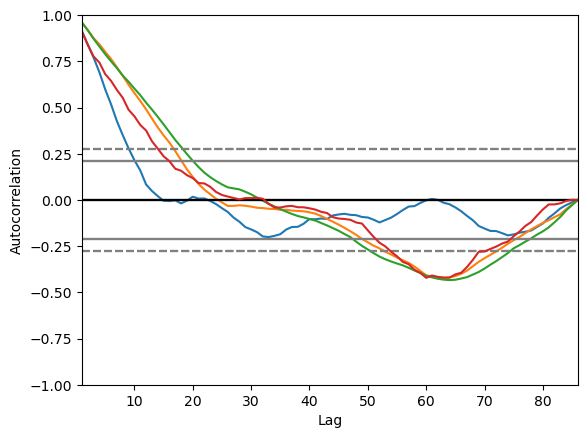

In [66]:
pd.plotting.autocorrelation_plot(df['connor'])
pd.plotting.autocorrelation_plot(df['helio'])
pd.plotting.autocorrelation_plot(df['sam'])
pd.plotting.autocorrelation_plot(df['guest'])

## Trend decomposition
We suspect that a players performance over time is an additive function of some linear trend with noise. We can verify this by taking a trend decomposition of net profit/loss. 

In [67]:
# Calculate Interesting Stats

# 1. Average games per night
games_per_night = df_data.groupby('date')['game_num'].max().mean()
print(f"Avg games per night: {games_per_night:.2f}")

# 2. Dealer Win Rate
dealer_wins = df_data['dealer_win'].dropna()
if dealer_wins.empty:
    dealer_win_rate = 0
else:
    dealer_win_rate = dealer_wins.mean()
print(f"Dealer Win Rate: {dealer_win_rate:.2%}")

# 3. Self Draw Rate
from_wall_counts = df_data['from_wall'].dropna()
if not from_wall_counts.empty:
    self_draw_rate = from_wall_counts.mean()
else:
    self_draw_rate = 0
print(f"Self Draw Rate: {self_draw_rate:.2%}")

# 4. Player Stats (Win Rate, Avg Fan, Points)
player_stats = []
big3 = ['connor','helio','sam']
guests = ['oscar','nick','drew','ruohan','brandon','lixin','alice','eileen']
all_players_list = big3 + guests

for p in all_players_list:
    p_data = df_data[p].dropna()
    games_played = len(p_data)
    if games_played > 0:
        wins = p_data[p_data > 0]
        losses = p_data[p_data < 0]
        win_rate = len(wins) / games_played
        
        # Avg Fan when winning
        win_indices = wins.index
        avg_win_fan = df_data.loc[win_indices, 'fan'].mean()
        
        # Avg Points
        avg_win_points = wins.mean() if not wins.empty else 0
        avg_loss_points = losses.mean() if not losses.empty else 0
        
        # Volatility (Standard Deviation)
        volatility = p_data.std()
        
        player_stats.append({
            'Player': p.capitalize(),
            'Games Played': games_played,
            'Win Rate': win_rate,
            'Avg Win Fan': f"{avg_win_fan:.1f}" if not pd.isna(avg_win_fan) else "0.0",
            'Avg Win Points': f"{avg_win_points:.1f}",
            'Avg Loss Points': f"{avg_loss_points:.1f}",
            'Net Profit': f"{int(p_data.sum())}",
            'Expected Points Per Hand': f"{p_data.mean():.2f}",
            'Volatility': f"{volatility:.2f}"
        })

# Guest Aggregate Stats
guest_series_list = [df_data[g].dropna() for g in guests]
guest_data = pd.concat(guest_series_list)
games_played = len(guest_data)
if games_played > 0:
    wins = guest_data[guest_data > 0]
    losses = guest_data[guest_data < 0]
    win_rate = len(wins) / games_played
    
    # Avg Fan (using indices from concatenated series)
    win_indices = wins.index
    avg_win_fan = df_data.loc[win_indices, 'fan'].mean()
    
    avg_win_points = wins.mean() if not wins.empty else 0
    avg_loss_points = losses.mean() if not losses.empty else 0
    
    volatility = guest_data.std()
    
    player_stats.append({
        'Player': 'Guest (aggregate)',
        'Games Played': games_played,
        'Win Rate': win_rate,
        'Avg Win Fan': f"{avg_win_fan:.1f}" if not pd.isna(avg_win_fan) else "0.0",
        'Avg Win Points': f"{avg_win_points:.1f}",
        'Avg Loss Points': f"{avg_loss_points:.1f}",
        'Net Profit': f"{int(guest_data.sum())}",
        'Expected Points Per Hand': f"{guest_data.mean():.2f}",
        'Volatility (Std)': f"{volatility:.2f}"
    })

stats_df = pd.DataFrame(player_stats)
# Sort by Games Played descending
stats_df = stats_df.sort_values(by='Games Played', ascending=False)
# Format Win Rate as percentage for display
stats_df['Win Rate'] = stats_df['Win Rate'].map(lambda x: f"{x:.2%}")

# Save to CSV
stats_df.to_csv("player_stats.csv", index=False)
print("player_stats.csv updated successfully.")

display(stats_df)


Avg games per night: 6.69
Dealer Win Rate: 17.65%
Self Draw Rate: 29.41%
player_stats.csv updated successfully.


,Player,Games Played,Win Rate,Avg Win Fan,Avg Win Points,Avg Loss Points,Net Profit,Expected Points Per Hand,Volatility,Volatility (Std)
0,Connor,85,27.06%,7.5,141.9,-42.5,632,7.44,111.84,NaN
1,Helio,85,27.06%,9.6,210.1,-38.2,2466,29.01,151.10,NaN
2,Sam,85,11.76%,6.3,129.6,-50.2,-2466,-29.01,82.62,NaN
11,Guest (aggregate),85,34.12%,4.4,81.9,-53.7,-632,-7.44,NaN,90.56
6,Ruohan,23,34.78%,4.5,72.0,-59.7,-320,-13.91,96.37,NaN
3,Oscar,12,41.67%,3.6,54.4,-52.6,-96,-8.00,68.39,NaN
10,Eileen,11,27.27%,2.7,42.7,-63.0,-376,-34.18,65.78,NaN
5,Drew,10,20.00%,7.0,224.0,-50.0,48,4.80,141.52,NaN
4,Nick,9,55.56%,5.2,92.8,-68.0,192,21.33,110.56,NaN
7,Brandon,8,12.50%,4.0,64.0,-30.9,-152,-19.00,37.26,NaN


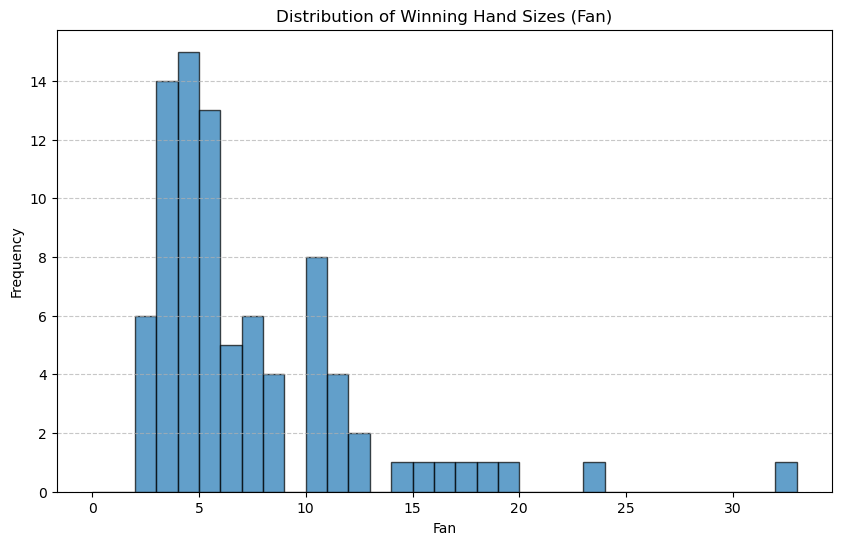

In [68]:
# Histogram of Winning Hand Sizes (Fan)
plt.figure(figsize=(10, 6))
plt.hist(df_data['fan'].dropna(), bins=range(0, int(df_data['fan'].max()) + 2, 1), edgecolor='black', alpha=0.7)
plt.title('Distribution of Winning Hand Sizes (Fan)')
plt.xlabel('Fan')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("fan_distribution.png", bbox_inches='tight')
plt.show()


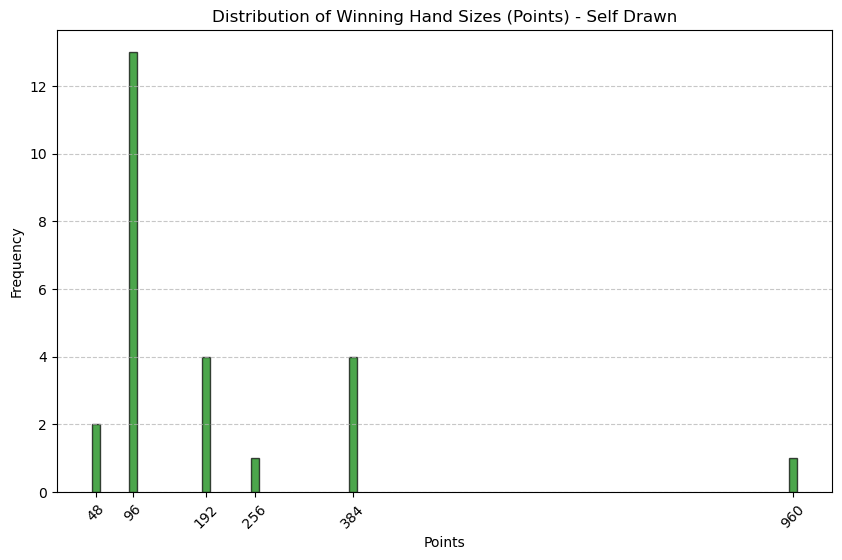

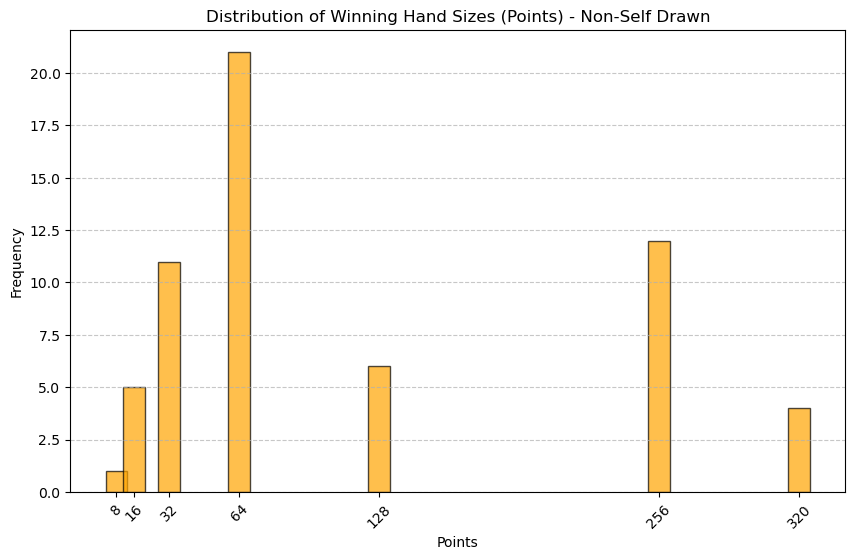

In [69]:
# Histograms of Winning Hand Sizes (Points)

current_big3 = ['connor','helio','sam']
current_guests = ['oscar','nick','drew','ruohan','brandon','lixin','alice','eileen']
current_players = current_big3 + current_guests

# Extract winning points (max score in row)
winning_points = df_data[current_players].max(axis=1)

self_drawn_points = winning_points[df_data['from_wall'] == 1]
discard_points = winning_points[df_data['from_wall'] == 0]

# Plot 1: Self-Drawn
plt.figure(figsize=(10, 6))
self_drawn_counts = self_drawn_points.dropna().value_counts().sort_index()
plt.bar(self_drawn_counts.index, self_drawn_counts.values, width=10, edgecolor='black', alpha=0.7, color='green')
plt.title('Distribution of Winning Hand Sizes (Points) - Self Drawn')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.xticks(self_drawn_counts.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("win_points_self_drawn.png", bbox_inches='tight')
plt.show()

# Plot 2: Non-Self-Drawn
plt.figure(figsize=(10, 6))
discard_counts = discard_points.dropna().value_counts().sort_index()
plt.bar(discard_counts.index, discard_counts.values, width=10, edgecolor='black', alpha=0.7, color='orange')
plt.title('Distribution of Winning Hand Sizes (Points) - Non-Self Drawn')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.xticks(discard_counts.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("win_points_non_self_drawn.png", bbox_inches='tight')
plt.show()


In [70]:
# Top 5 Largest Hands

hand_data = []

for index, row in df_data.iterrows():
    # Fan
    fan = row['fan']
    if pd.isna(fan):
        continue
    
    # Points (Winner's score)
    scores = row[current_players]
    points = scores.max()
    
    if pd.isna(points) or points <= 0:
        continue

    # Identify Player
    # idxmax returns the index (player name) of the max value
    winner = scores.idxmax()

    # Self Drawn?
    is_self_drawn = "Yes" if row['from_wall'] == 1 else "No"
    
    hand_data.append({
        'Date': row['date'],
        'Player': winner.capitalize(),
        'Fan': int(fan),
        'Points': int(points),
        'Self Drawn': is_self_drawn
    })

hands_df = pd.DataFrame(hand_data)
hands_df = hands_df.sort_values(by=['Fan', 'Points'], ascending=[False, False])
top_5 = hands_df.head(5)

display(top_5)


,Date,Player,Fan,Points,Self Drawn
25,10/3/2025,Helio,32,960,Yes
61,1/28/2026,Helio,23,256,No
57,12/12/2025,Connor,19,320,No
7,8/29/2025,Connor,18,320,No
68,2/6/2026,Connor,17,320,No


In [71]:
# Recent Night Summary

df_data['date_obj'] = pd.to_datetime(df_data['date'], format='mixed', dayfirst=False)
last_date = df_data['date_obj'].max()
date_str = last_date.strftime('%m/%d/%Y')

recent_df = df_data[df_data['date_obj'] == last_date]
games_count = len(recent_df)

numeric_cols = df_data.select_dtypes(include=[np.number]).columns
exclude = ['date', 'game_num', 'order_starting_at_east', 'fan', 'from_wall', 'dealer_win', 'tiles_remaining', 'date_obj', 'guest']
players = [c for c in numeric_cols if c not in exclude]

night_players = []
for p in players:
    if not recent_df[p].isna().all():
        night_players.append(p)

summary_data = []

for p in night_players:
    profit = recent_df[p].sum()
    
    p_wins = recent_df[recent_df[p] > 0]
    hands_won = len(p_wins)
    
    if not p_wins.empty:
        max_hand = p_wins[p].max()
        high_hand_str = str(int(max_hand))
    else:
        high_hand_str = "0"

    history_df = df_data[df_data['date_obj'] < last_date]
    p_history = history_df[p].dropna()
    prev_stat = p_history.mean() if not p_history.empty else 0.0
    prev_std = p_history.std() if not p_history.empty else 1.0
    
    p_current = recent_df[p].dropna()
    curr_stat = p_current.mean()
    
    # Z-Score of the night's average performance
    if prev_std > 0:
        z_score = (curr_stat - prev_stat) / prev_std
    else:
        z_score = 0.0
        
    diff = curr_stat - prev_stat
    
    summary_data.append({
        'Player': p.capitalize(),
        'Net Profit': profit,
        'Highest Hand': high_hand_str,
        'Hands Won': hands_won,
        'Diff': diff,
        'Z-Score': z_score
    })

summary_data.sort(key=lambda x: x['Net Profit'], reverse=True)

print(f"### Most Recent Night: {date_str} ({games_count} Hands played)")
print("| Player | Net Profit | Highest Hand | Hands Won | Δ Avg Points per hand | Z-Score |")
print("| :--- | :--- | :--- | :--- | :--- | :--- |")

for row in summary_data:
    p = row['Player']
    prof = int(row['Net Profit'])
    hh = row['Highest Hand']
    won = row['Hands Won']
    diff = row['Diff']
    z = row['Z-Score']
    
    if prof > 0:
        prof_str = f"$\\color{{green}}{{+{prof}}}$"
    elif prof < 0:
        prof_str = f"$\\color{{red}}{{{prof}}}$"
    else:
        prof_str = f"{prof}"
        
    if diff > 0:
        diff_str = f"$\\color{{green}}{{+{diff:.2f}}}$"
    elif diff < 0:
        diff_str = f"$\\color{{red}}{{{diff:.2f}}}$"
    else:
        diff_str = f"{diff:.2f}"
        
    if z > 0:
        z_str = f"+{z:.2f}"
    else:
        z_str = f"{z:.2f}"
        
    print(f"| {p} | {prof_str} | {hh} | {won} | {diff_str} | {z_str} |")


### Most Recent Night: 02/13/2026 (11 Hands played)
| Player | Net Profit | Highest Hand | Hands Won | Δ Avg Points per hand | Z-Score |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Helio | $\color{green}{+288}$ | 384 | 2 | $\color{red}{-3.25}$ | -0.02 |
| Sam | $\color{green}{+204}$ | 256 | 4 | $\color{green}{+54.63}$ | +0.78 |
| Connor | $\color{red}{-116}$ | 256 | 2 | $\color{red}{-20.65}$ | -0.18 |
| Eileen | $\color{red}{-376}$ | 96 | 3 | $\color{red}{-34.18}$ | -34.18 |


In [72]:
# Update Betting Odds if new data is present
import os
import subprocess

# Define paths
# Note: We are in 'Season 2 Data/' directory when running this notebook
# The counter file will be stored in 'Gambling and Forecasting/'
counter_file_path = "../Gambling and Forecasting/processed_night_count.txt"
script_relative_path = "Gambling and Forecasting/generate_betting_odds.py"

# Get current number of nights
current_night_count = df_data['date'].nunique()

# Read previous count
previous_night_count = 0
if os.path.exists(counter_file_path):
    with open(counter_file_path, "r") as f:
        try:
            previous_night_count = int(f.read().strip())
        except ValueError:
            previous_night_count = 0

print(f"Current Nights: {current_night_count}, Previous Processed: {previous_night_count}")

if current_night_count > previous_night_count:
    print("New night of data detected! Running betting odds script...")
    
    # The script expects to be run from the project root to find 'Season 2 Data/data.csv'
    # We get the project root by going up one level from the current working directory
    project_root = os.path.abspath("..")
    
    try:
        # Run the script
        result = subprocess.run(
            ["python3", script_relative_path],
            cwd=project_root,
            capture_output=True,
            text=True,
            check=True
        )
        print("Betting odds generated successfully.")
        print(result.stdout)
        
        # Update the counter file
        with open(counter_file_path, "w") as f:
            f.write(str(current_night_count))
            
    except subprocess.CalledProcessError as e:
        print("Error running betting odds script:")
        print(e.stderr)
else:
    print("No new nights detected. Skipping betting odds generation.")

Current Nights: 13, Previous Processed: 13
No new nights detected. Skipping betting odds generation.


In [73]:
# Update README.md with Most Recent Night summary
import update_readme
update_readme.update_readme()

README.md updated successfully.
